In [1]:
import sys
from h5_utils import h5disp, h5read
import prediction_utils
from correlation_metrics import get_split_half_correlation
import numpy as np
import os
from plot_utils import journal_figure
import matplotlib.pyplot as plt

In [2]:
nrImages = 1320

In [3]:
from decode_utils import decode, get_percent_correct_from_proba, get_fa, get_dprime

def create_i1_i2(model_features_):
    lb = ['bear','elephant','person','car','dog','apple','chair','plane','bird','zebra']
    labels = np.repeat(lb, 132,axis=0)
    i1 = np.zeros((nrImages,20), dtype=float) 
    i2 = np.zeros((20, nrImages,len(lb)), dtype=float) 
    dp_m = np.zeros((nrImages,20), dtype=float) 
    i1[:]=np.nan 
    i2[:]=np.nan 
    for j in range(20): 
        print('nrBS: '+str(j)) 
        p = decode(model_features_,labels, seed=j, nrfolds=3) 
        pc = get_percent_correct_from_proba(p,labels, np.array(lb)) 
        i1[:,j] = np.nanmean(pc, axis=1) 
        i2[j] = pc
    return i1, i2

In [4]:
def select_neurons(ev, selected_rates):  
    print(ev.shape, selected_rates.shape)  
    selected_rates = np.array(selected_rates[:, :ev.shape[0]])  
    best_neurons = selected_rates[:,ev > np.nanpercentile(ev, 80, axis=0)]  
    worst_neurons = selected_rates[:,ev < np.nanpercentile(ev, 20, axis=0)]  
    return best_neurons, worst_neurons

In [5]:
def load_model_features(model):
    path_map = {
        #"alexnet": "model_features/alexnet_features.npy",
        "alexnet_relu": "model_features/alexnet_features_layer_last.npy",
        "resnet": "model_features/resnet_features.npy",
        "resnet18": "model_features/resnet18_features.npy",
        "resnet18_ssl": "model_features/resnet18_ssl_features.npy",
        "resnet18_robust": "model_features/resnet18_robust_features.npy",
        "resnet_ssl": "model_features/resnet50_ssl_features.npy",
        "resnet_swsl": "model_features/resnet50_swsl_features.npy",
        "resnetSIN": "model_features/resnetSIN_features.npy",
        #"resnet152": "model_features/resnet152_features.npy",
        "resnet152_2": "model_features/resnet152_2_features.npy",
        "resnet101": "model_features/resnet101_features.npy",
        "resnet101_ssl": "model_features/resnet101_ssl_features.npy",
        "resnet_robust_eps1": "model_features/resnet_robust_eps1_features.npy",
        "resnet_robust_eps3": "model_features/resnet_robust_eps3_features.npy",
        "inception": "model_features/inceptionv3_features.npy",
        "inceptionv1": "model_features/inceptionv1_features.npy",
        "vit": "model_features/vit_features.npy",
        "vit_ssl": "model_features/vit_ssl_features.npy",
        "vgg16": "model_features/vgg16_features.npy",
        "vgg16_robust": "model_features/vgg16_robust_eps3_features.npy",
        "densenet": "model_features/densenet_features.npy",
        "densenet169": "model_features/densenet169_features.npy",
        "densenet161": "model_features/densenet161_features.npy",
        "densenet161_robust": "model_features/densenet161_robust_eps3_features.npy",
        "densenet121": "model_features/densenet121_features.npy",
        "convnext": "model_features/convnext_features.npy",
        "convnext_ssl": "model_features/convnext_ssl_features.npy",
        "mobilenet": "model_features/mobilenet_features.npy",
        "mobilenet_v2": "model_features/mobilenet_v2_features.npy",
        "mobilenet_robust": "model_features/mobilenet_robust_eps3_features.npy",
        "squeezenet": "model_features/squeezenet_features.npy",
        #"cornetS": "model_features/cornetS_features.npy",
        "cornetS_t0": "model_features/CORnet-S_muri1320_IT_output_feats_ts_0.npy",
        "cornetS_reg": "model_features/cornetS_regularized_features.npy",
        "cornetRT_t4": "model_features/CORnet-RT_muri1320_IT_output_feats_ts_4.npy",
        "nasnet": "model_features/nasnet_features.npy",
        "pnasnet": "model_features/pnasnet_features.npy",
        "swin": "model_features/swin_features.npy",
        "swin_ssl": "model_features/swin_ssl_features.npy",
        "shufflenet": "model_features/shufflenet_features.npy",
        "shufflenet_robust": "model_features/shufflenet_robust_features.npy",
    }
    if model not in path_map:
        raise ValueError("Model not found")
    features = np.load(path_map[model])
    return features.reshape((1320, -1))

In [61]:
full_model_list = ["alexnet_relu", "resnet18", "resnet18_robust", "resnet18_ssl", "resnet", "resnet_ssl", "resnet_swsl", "resnetSIN", "resnet152_2", "resnet101", "resnet101_ssl", "resnet_robust_eps1", "resnet_robust_eps3", "inception", "inceptionv1", "vit", "vit_ssl", "vgg16", "vgg16_robust", "densenet", "densenet169", "densenet161", "densenet161_robust", "densenet121", "convnext", "convnext_ssl", "mobilenet", "mobilenet_v2", "mobilenet_robust", "squeezenet", "cornetS_t0", "cornetS_reg", "cornetRT_t4", "nasnet", "pnasnet", "swin", "swin_ssl", "shufflenet", "shufflenet_robust"] #, "cornetS_reg"


In [6]:
prev_model_list = ["alexnet_relu", "resnet", "resnetSIN", "resnet152_2", "resnet101", "resnet_robust_eps1", "resnet_robust_eps3", "inception", "inceptionv1", "densenet", "densenet169", "densenet121", "vgg16", "vit", "convnext", "mobilenet", "squeezenet", "cornetS_t0", "cornetRT_t4", "nasnet", "pnasnet"]

In [47]:
good_neurons_models_monkeys = {}
for model in full_model_list:
    features = load_model_features(model)
    good_neurons_models_monkeys[model] = {}
    for monkey in ["magneto", "nano"]:
        good_neurons_models_monkeys[model][monkey] = {}
        ev_per_neuron = np.load(f'./results_predictions/monkey2model/v4/{monkey}/ev_{model}.npy')
        best_neurons, worst_neurons = select_neurons(ev_per_neuron, features)
        good_neurons_models_monkeys[model][monkey]["good"] = best_neurons
        good_neurons_models_monkeys[model][monkey]["bad"] = worst_neurons


(4096,) (1320, 4096)
(4096,) (1320, 4096)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(200704,) (1320, 200704)
(200704,) (1320, 200704)
(200704,) (1320, 200704)
(200704,) (1320, 200704)
(200704,) (1320, 200704)
(200704,) (1320, 200704)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(32000,) (1320, 32000)
(32000,) (1320, 32000)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(151296,) (1320, 151296)
(151296,) (1320, 151296)
(75648,) (1320, 75648)
(75648,) (1320, 75648)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(200704,) (1320, 200704)
(200704,) (1320, 200704)
(43904,) (1320, 43904)
(43904,) (1320, 43904)
(31360,) (1320, 31360)
(31360,) 

In [11]:
good_neurons_models_monkeys_one_to_one = {}
for model in prev_model_list:
    features = load_model_features(model)
    good_neurons_models_monkeys_one_to_one[model] = {}
    for monkey in ["magneto", "nano"]:
        good_neurons_models_monkeys_one_to_one[model][monkey] = {}
        ev_per_neuron = np.load(f'./results_reverse_prediction_full/{model}/ev_reverse_{monkey}.npy')

        best_neurons, worst_neurons = select_neurons(ev_per_neuron, features)
        good_neurons_models_monkeys_one_to_one[model][monkey]["good"] = best_neurons
        good_neurons_models_monkeys_one_to_one[model][monkey]["bad"] = worst_neurons

(4063,) (1320, 4096)
(3714,) (1320, 4096)
(100352,) (1320, 100352)
(100349,) (1320, 100352)
(99228,) (1320, 100352)
(99228,) (1320, 100352)
(200681,) (1320, 200704)
(200681,) (1320, 200704)
(200610,) (1320, 200704)
(200610,) (1320, 200704)
(100351,) (1320, 100352)
(100351,) (1320, 100352)
(100352,) (1320, 100352)
(100352,) (1320, 100352)
(31916,) (1320, 32000)
(31916,) (1320, 32000)
(98358,) (1320, 100352)
(98358,) (1320, 100352)
(43904,) (1320, 43904)
(43904,) (1320, 43904)
(31360,) (1320, 31360)
(31360,) (1320, 31360)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(99344,) (1320, 100352)
(99344,) (1320, 100352)
(151296,) (1320, 151296)
(151296,) (1320, 151296)
(75264,) (1320, 75264)
(75264,) (1320, 75264)
(10976,) (1320, 10976)
(10976,) (1320, 10976)
(29220,) (1320, 32448)
(29220,) (1320, 32448)
(25088,) (1320, 25088)
(25088,) (1320, 25088)
(10992,) (1320, 25088)
(10992,) (1320, 25088)
(197568,) (1320, 197568)
(197568,) (1320, 197568)
(211680,) (1320, 211680)
(211680,) (1320, 211680)


In [9]:
%%capture --no-display
i1s_models_monkeys = {}
model = "resnet" #for model in full_model_list:
i1s_models_monkeys[model] = {}
print(f"Processing model: {model}")
monkey = "magneto" #for monkey in ["magneto", "nano"]:
out_dir = f'./results_behavior/{model}/{monkey}/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
if not os.path.exists(f'./results_behavior/{model}/{monkey}/i1_bad.npy'):
    i1s_models_monkeys[model][monkey] = {}
    bad_neurons = good_neurons_models_monkeys[model][monkey]["bad"]
    
    if model != "alexnet_relu":
        proj = np.random.randn(good_neurons.shape[1], 813)
        good_neurons = np.dot(good_neurons, proj)
        bad_neurons = np.dot(bad_neurons, proj)

    i1_bad, _ = create_i1_i2(bad_neurons.T)

    np.save(f'./results_behavior/{model}/{monkey}/i1_bad.npy', i1_bad)

    i1s_models_monkeys[model][monkey]["bad"] = i1_bad

In [16]:
good_neurons = good_neurons_models_monkeys[model][monkey]["good"]
if model != "alexnet_relu":
    proj = np.random.randn(good_neurons.shape[1], 813)
    good_neurons = np.dot(good_neurons, proj)

In [19]:
good_neurons.shape

(1320, 813)

In [80]:
%%capture --no-display
rng = np.random.default_rng(seed=111)
# sample units in the good units from 10 to 800
model = "resnet"
for monkey in ["magneto", "nano"]:
    for sample_size in range(200, 300, 20):
        i1s_good = []
        for r in range(5):
            indices = rng.choice(good_neurons.shape[1], sample_size, replace=False)
            sampled_good_neurons = good_neurons[:, indices]

            i1_good, _ = create_i1_i2(sampled_good_neurons.T)
            i1s_good.append(i1_good)

        np.save(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy', i1s_good)


In [ ]:
%%capture --no-display
rng = np.random.default_rng(seed=111)
for model in full_model_list:
    for monkey in ["magneto", "nano"]:

        good_neurons = good_neurons_models_monkeys[model][monkey]["good"]
        if model != "alexnet_relu":
            proj = np.random.randn(good_neurons.shape[1], 813)
            good_neurons = np.dot(good_neurons, proj)

        for sample_size in range(150, 350, 20):
            i1s_good = []
            if not os.path.exists(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy'):
                for r in range(5):
                    indices = rng.choice(good_neurons.shape[1], sample_size, replace=False)
                    sampled_good_neurons = good_neurons[:, indices]

                    i1_good, _ = create_i1_i2(sampled_good_neurons.T)
                    i1s_good.append(i1_good)

                np.save(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy', i1s_good)


In [ ]:
good_neurons_models_monkeys_one_to_one[model][monkey]["good"]

In [16]:
%%capture --no-display
rng = np.random.default_rng(seed=111)
for model in prev_model_list:
    for monkey in ["magneto", "nano"]:

        good_neurons = good_neurons_models_monkeys_one_to_one[model][monkey]["good"]
        if model != "alexnet_relu":
            proj = np.random.randn(good_neurons.shape[1], 813)
            good_neurons = np.dot(good_neurons, proj)

        for sample_size in range(550, 800, 20):
            i1s_good = []
            if not os.path.exists(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}_one_to_one.npy'):
                for r in range(5):
                    indices = rng.choice(good_neurons.shape[1], sample_size, replace=True)
                    sampled_good_neurons = good_neurons[:, indices]

                    i1_good, _ = create_i1_i2(sampled_good_neurons.T)
                    i1s_good.append(i1_good)

                np.save(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}_one_to_one.npy', i1s_good)


In [131]:
model

'mobilenet_robust'

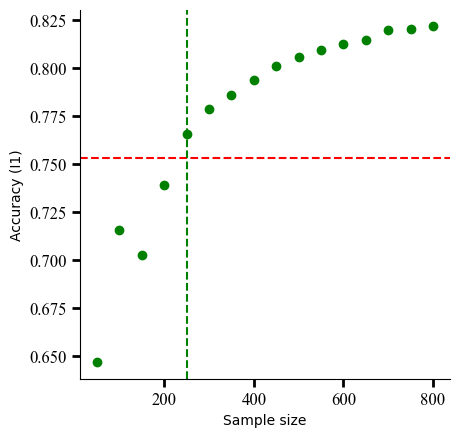

In [72]:
#find the closest sample size to match i1_bad
i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
plt.axhline(i1_bad.mean(), color='red', linestyle='--', label='bad units')

best_match = None
for sample_size in range(50, 801, 50):
    i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy')
    plt.scatter(sample_size, np.mean(i1_good), color="green")
    if best_match is None or abs(np.mean(i1_good) - np.mean(i1_bad)) < abs(np.mean(best_match) - np.mean(i1_bad)):
        sample_size_best_match = sample_size
        best_match = i1_good

plt.xlabel("Sample size")
plt.ylabel("Accuracy (I1)")
plt.axvline(sample_size_best_match, color='green', linestyle='--', label='best match')
journal_figure()

In [64]:
import distinctipy
colors = distinctipy.get_colors(len(full_model_list))

In [7]:
import distinctipy
colors = distinctipy.get_colors(len(prev_model_list))

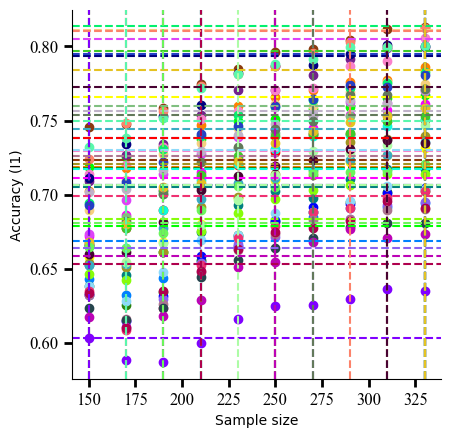

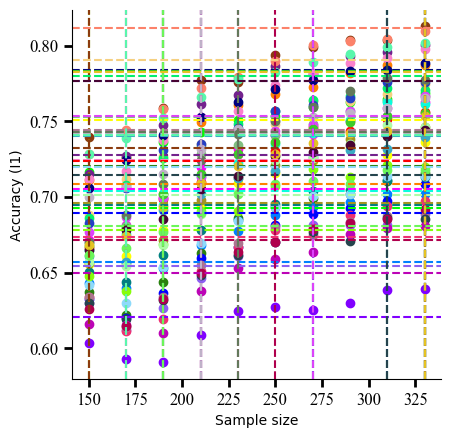

In [65]:
sample_size_best_match_all = {}
for monkey in ["magneto", "nano"]:

    sample_size_best_match_all[monkey] = {}
    for i, model in enumerate(full_model_list):    
        #find the closest sample size to match i1_bad
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
        plt.axhline(i1_bad.mean(), color=colors[i], linestyle='--', label='bad units')

        best_match = None
        for sample_size in range(150, 350, 20):
            i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy')
            plt.scatter(sample_size, np.mean(i1_good), color=colors[i])
            if best_match is None or (abs(np.mean(i1_good) - np.mean(i1_bad)) < abs(np.mean(best_match) - np.mean(i1_bad)) and np.mean(i1_good) < np.mean(i1_bad)):
                sample_size_best_match = sample_size
                best_match = i1_good

        sample_size_best_match_all[monkey][model] = sample_size_best_match
        
        plt.axvline(sample_size_best_match, color=colors[i], linestyle='--', label='best match')

    plt.xlabel("Sample size")
    plt.ylabel("Accuracy (I1)")  
    journal_figure()
    plt.show()


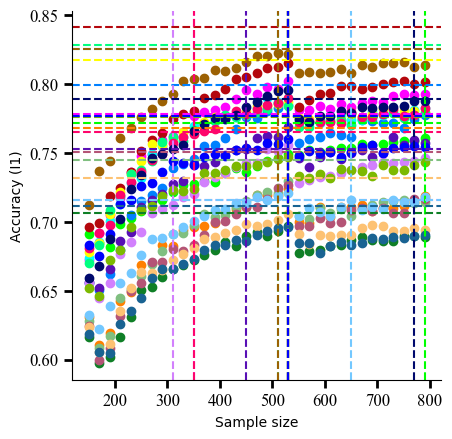

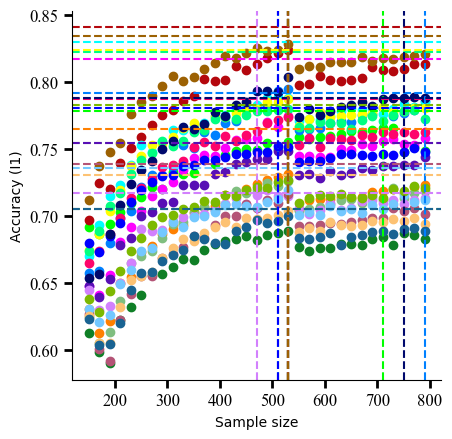

In [18]:
sample_size_best_match_all_one_to_one = {}
for monkey in ["magneto", "nano"]:

    sample_size_best_match_all_one_to_one[monkey] = {}
    for i, model in enumerate(prev_model_list):    
        #find the closest sample size to match i1_bad
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/one_to_one_i1_bad.npy')
        plt.axhline(i1_bad.mean(), color=colors[i], linestyle='--', label='bad units')

        best_match = None
        for sample_size in range(150, 800, 20):
            i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}_one_to_one.npy')
            plt.scatter(sample_size, np.mean(i1_good), color=colors[i])
            if best_match is None or (abs(np.mean(i1_good) - np.mean(i1_bad)) < abs(np.mean(best_match) - np.mean(i1_bad)) and np.mean(i1_good) < np.mean(i1_bad)):
                sample_size_best_match = sample_size
                best_match = i1_good

        sample_size_best_match_all_one_to_one[monkey][model] = sample_size_best_match
        
        plt.axvline(sample_size_best_match, color=colors[i], linestyle='--', label='best match')

    plt.xlabel("Sample size")
    plt.ylabel("Accuracy (I1)")  
    journal_figure()
    plt.show()


Best match for magneto: 240


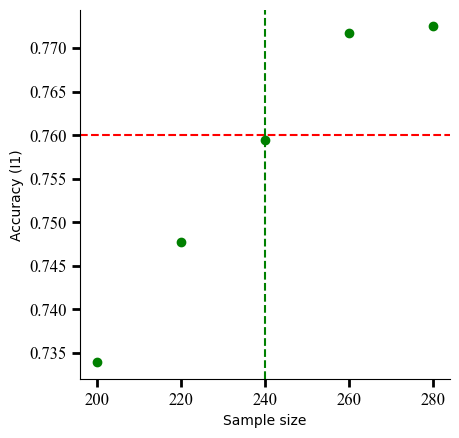

Best match for nano: 220


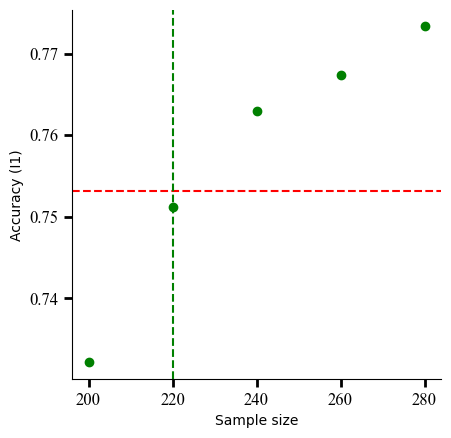

In [109]:
sample_size_best_match_ = {}
#find the closest sample size to match i1_bad
for monkey in ["magneto", "nano"]:
    
    i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
    plt.axhline(i1_bad.mean(), color='red', linestyle='--', label='bad units')

    best_match = None
    for sample_size in range(200, 300, 20):
        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size}.npy')
        plt.scatter(sample_size, np.mean(i1_good), color="green")
        if best_match is None or abs(np.mean(i1_good) - np.mean(i1_bad)) < abs(np.mean(best_match) - np.mean(i1_bad)):
            sample_size_best_match = sample_size
            best_match = i1_good
    
    sample_size_best_match_[monkey] = sample_size_best_match

    plt.xlabel("Sample size")
    plt.ylabel("Accuracy (I1)")
    plt.axvline(sample_size_best_match, color='green', linestyle='--', label='best match')
    print(f"Best match for {monkey}: {sample_size_best_match}")
    journal_figure()
    plt.show()

In [74]:
def compute_correlation(d1, d2):
    rand_r1 = np.random.choice(20, size=20, replace=True)
    rand_r2 = np.random.choice(20, size=20, replace=True)
    corrs_i1 = [
        pearsonr(d1[:,r1], d2[:, r2])[0] for r1, r2 in zip(rand_r1, rand_r2)
    ]
    mean_corr = np.nanmean(corrs_i1)
    std_corr = np.nanstd(corrs_i1)
    return mean_corr, std_corr, corrs_i1

def compute_all_correlations(i1_model_best, i1_model_worst, i1_b, ceiling_b=1.0):
    corr_best_m, corr_best_std, corrs_i1_best = compute_correlation(i1_b, i1_model_best)
    corr_worst_m, corr_worst_std, corrs_i1_worst = compute_correlation(i1_b, i1_model_worst)

    corr_best_m_corr = corr_best_m/np.sqrt(ceiling_b)
    corr_worst_m_corr = corr_worst_m/np.sqrt(ceiling_b)

    return corr_best_m_corr, corr_worst_m_corr, corrs_i1_best, corrs_i1_worst

In [75]:
from scipy.stats import spearmanr, pearsonr

In [76]:
from scipy.stats import median_abs_deviation as mad
def nanmad(var):
    return mad(np.nan_to_num(var))

In [161]:
i1_bad.shape

(1320, 20)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


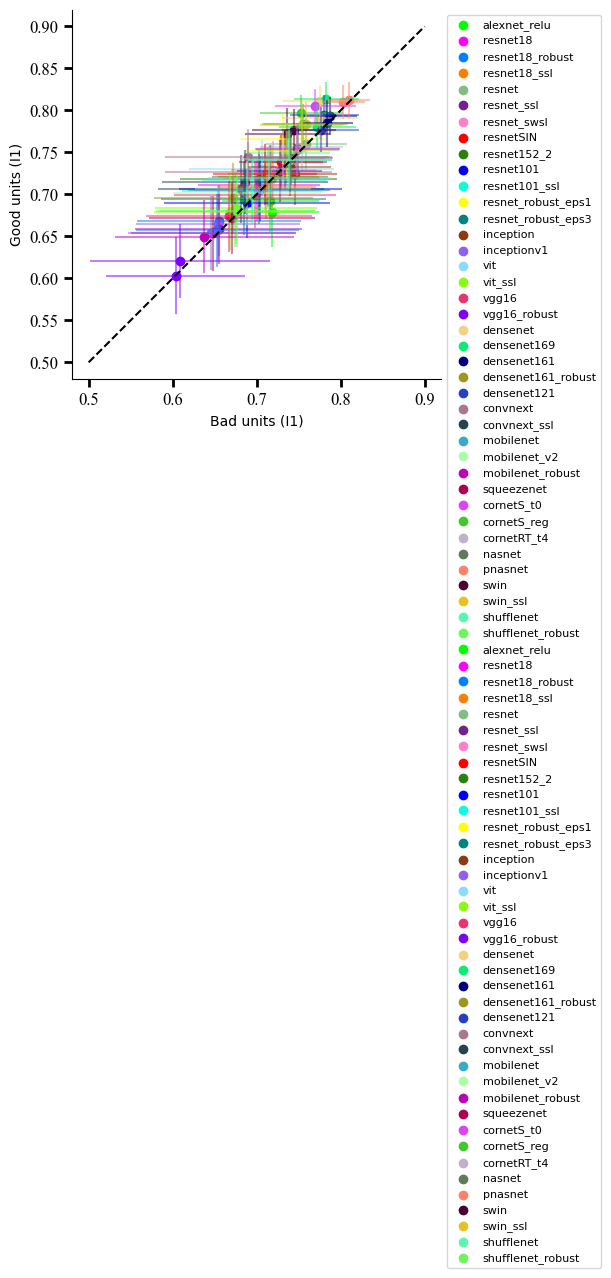

In [68]:
accs_bad = []
accs_good = []
for monkey in ["magneto", "nano"]:
    for model in full_model_list:
        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all[monkey][model]}.npy')
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
        #print(i1_bad.mean())
        accuracies = []
        mads = []
        for r in range(i1_good.shape[0]):
            accuracy = np.nanmean(i1_good[r])
            accuracies.append(accuracy)
            mads.append(nanmad(i1_good[r]))
            #print(f"Run {r}: mean accuracy {accuracy}")

        plt.scatter(np.nanmean(accuracies), i1_bad.mean(), color=colors[full_model_list.index(model)], label=model)
        plt.errorbar(np.nanmean(accuracies), i1_bad.mean(),
                     yerr=nanmad(i1_bad.mean(axis=1).flatten())/np.sqrt(20), xerr=np.nanmean(mads)/np.sqrt(5), color=colors[full_model_list.index(model)], alpha=0.5)
        accs_bad.append(i1_bad.mean())
        accs_good.append(np.nanmean(accuracies))

plt.plot([0.5, 0.9], [0.5, 0.9], color='black', linestyle='--')
plt.xlabel("Bad units (I1)")
plt.ylabel("Good units (I1)")
journal_figure()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.savefig(f"./results_behavior/accuracies_common_vs_uncommon.eps", dpi=300, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


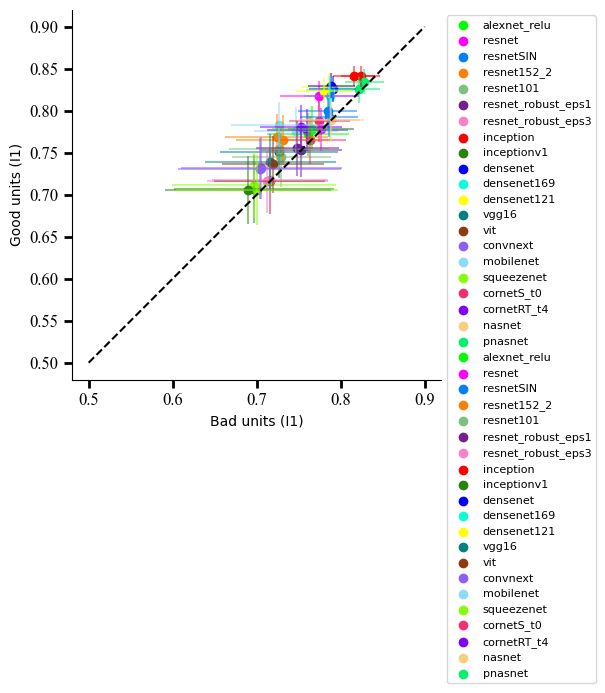

In [69]:
accs_bad = []
accs_good = []
for monkey in ["magneto", "nano"]:
    for model in prev_model_list:
        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all_one_to_one[monkey][model]}_one_to_one.npy')
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/one_to_one_i1_bad.npy')
        #print(i1_bad.mean())
        accuracies = []
        mads = []
        for r in range(i1_good.shape[0]):
            accuracy = np.nanmean(i1_good[r])
            accuracies.append(accuracy)
            mads.append(nanmad(i1_good[r]))
            #print(f"Run {r}: mean accuracy {accuracy}")

        plt.scatter(np.nanmean(accuracies), i1_bad.mean(), color=colors[prev_model_list.index(model)], label=model)
        plt.errorbar(np.nanmean(accuracies), i1_bad.mean(),
                     yerr=nanmad(i1_bad.mean(axis=1).flatten())/np.sqrt(20), xerr=np.nanmean(mads)/np.sqrt(5), color=colors[prev_model_list.index(model)], alpha=0.5)
        accs_bad.append(i1_bad.mean())
        accs_good.append(np.nanmean(accuracies))

plt.plot([0.5, 0.9], [0.5, 0.9], color='black', linestyle='--')
plt.xlabel("Bad units (I1)")
plt.ylabel("Good units (I1)")
journal_figure()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.savefig(f"./results_behavior/accuracies_common_vs_uncommon_one_to_one.eps", dpi=300, bbox_inches='tight')


In [70]:
stats.shapiro(accs_bad), stats.shapiro(accs_good)

(ShapiroResult(statistic=np.float64(0.9479406429354973), pvalue=np.float64(0.05451435129935338)),
 ShapiroResult(statistic=np.float64(0.9503507346177862), pvalue=np.float64(0.06648032185272913)))

In [71]:
def print_ttest(commons, uniques):
    stat, p = stats.ttest_ind(commons, uniques, alternative='two-sided')
    dof = len(commons) + len(uniques) - 2
    print(f"t({dof}) = {stat}, p = {p}")

In [72]:
print_ttest(accs_good, accs_bad)

t(82) = -2.200690146145808, p = 0.030570059251772877


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


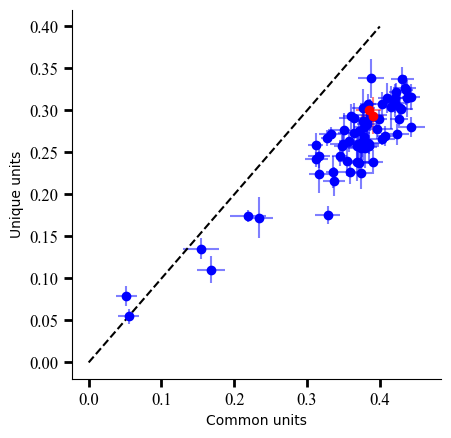

In [115]:
model = "resnet"
all_corrs_i1_best = []
all_corrs_i1_worst = []

delta_others = []
for model2 in full_model_list:
    if "cornet" not in model2:
        for monkey in ["magneto", "nano"]: #, "nano"
            i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_[monkey]}.npy').mean(axis=0)
            i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')

            i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

            corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
            if model != model2:
                delta_others.append(np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst))

            if model == model2:
                color = "red"
                plt.scatter(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), label=model, color=color, zorder=10)
                plt.errorbar(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), 
                            xerr=nanmad(corrs_i1_best), yerr=nanmad(corrs_i1_worst), color=color, alpha=0.5, zorder=0)
            else:
                color = "blue"
                plt.scatter(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), label=model, color=color, zorder=5)
                plt.errorbar(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), 
                            xerr=nanmad(corrs_i1_best), yerr=nanmad(corrs_i1_worst), color=color, alpha=0.5, zorder=0)
            
            all_corrs_i1_best.append(np.nanmean(corrs_i1_best))
            all_corrs_i1_worst.append(np.nanmean(corrs_i1_worst))

plt.plot([0, 0.4], [0, 0.4], color='black', linestyle='--')
#plt.scatter(np.nanmean(all_corrs_i1_best), np.nanmean(all_corrs_i1_worst), color="green", zorder=10)
plt.xlabel("Common units")
plt.ylabel("Unique units")
journal_figure()
plt.savefig(f"./results_behavior/correlation_{model}_behavior_corrected_for_accuracy.eps", dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


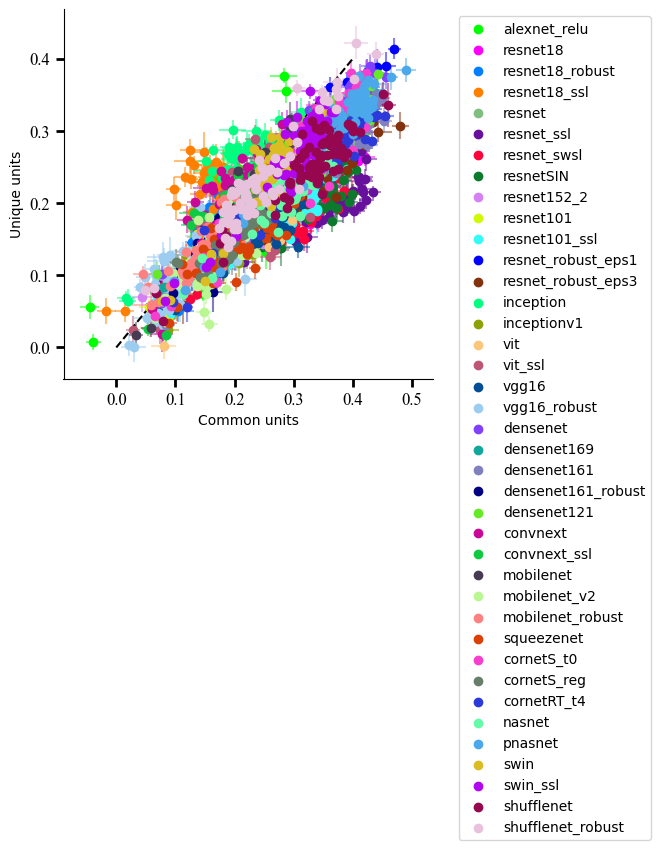

In [219]:
all_corrs_i1_best = []
all_corrs_i1_worst = []
for i, model in enumerate(full_model_list):

    for model2 in full_model_list:
        if "cornet" not in model2:
            for monkey in ["magneto", "nano"]: #, "nano"
                i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all[monkey][model]}.npy').mean(axis=0)
                i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')

                i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

                corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
                all_corrs_i1_best.append(np.nanmean(corrs_i1_best))
                all_corrs_i1_worst.append(np.nanmean(corrs_i1_worst))

                
                plt.scatter(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), label=model if (monkey=="magneto" and model2 == "alexnet_relu") else None, color=colors[i], zorder=5)
                plt.errorbar(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), 
                            xerr=nanmad(corrs_i1_best), yerr=nanmad(corrs_i1_worst), color=colors[i], alpha=0.5, zorder=0)

plt.plot([0, 0.4], [0, 0.4], color='black', linestyle='--')
#plt.scatter(np.nanmean(all_corrs_i1_best), np.nanmean(all_corrs_i1_worst), color="green", zorder=10)
plt.xlabel("Common units")
plt.ylabel("Unique units")
journal_figure()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f"./results_behavior/correlation_all_behavior_corrected_for_accuracy.eps", dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


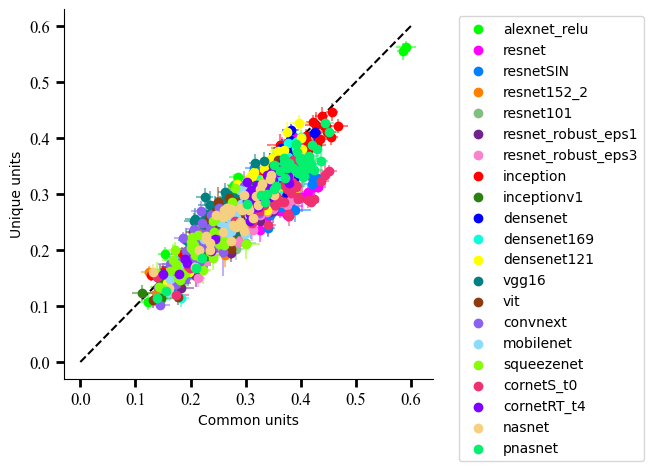

In [77]:
all_corrs_i1_best = []
all_corrs_i1_worst = []
for i, model in enumerate(prev_model_list):

    for model2 in prev_model_list:
        if "cornet" not in model2:
            for monkey in ["magneto", "nano"]: #, "nano"
                i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all_one_to_one[monkey][model]}_one_to_one.npy').mean(axis=0)
                i1_bad = np.load(f'./results_behavior/{model}/{monkey}/one_to_one_i1_bad.npy')

                i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

                corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
                all_corrs_i1_best.append(np.nanmean(corrs_i1_best))
                all_corrs_i1_worst.append(np.nanmean(corrs_i1_worst))

                
                plt.scatter(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), label=model if (monkey=="magneto" and model2 == "alexnet_relu") else None, color=colors[i], zorder=5)
                plt.errorbar(np.nanmean(corrs_i1_best), np.nanmean(corrs_i1_worst), 
                            xerr=nanmad(corrs_i1_best), yerr=nanmad(corrs_i1_worst), color=colors[i], alpha=0.5, zorder=0)

plt.plot([0, 0.6], [0, 0.6], color='black', linestyle='--')
#plt.scatter(np.nanmean(all_corrs_i1_best), np.nanmean(all_corrs_i1_worst), color="green", zorder=10)
plt.xlabel("Common units")
plt.ylabel("Unique units")
journal_figure()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f"./results_behavior/correlation_all_behavior_corrected_for_accuracy_one_to_one.eps", dpi=300, bbox_inches='tight')

In [78]:
import scipy.stats as stats
stats.shapiro(all_corrs_i1_best), stats.shapiro(all_corrs_i1_worst)

(ShapiroResult(statistic=np.float64(0.9838050742146978), pvalue=np.float64(1.0113119629857524e-07)),
 ShapiroResult(statistic=np.float64(0.9888870177847745), pvalue=np.float64(9.627539182792733e-06)))

In [79]:
def print_wilcoxon(commons, uniques):
    stat, p = stats.wilcoxon(commons, uniques, alternative='greater')
    dof = len(commons) - 1
    print(f"W({dof}) = {stat}, p = {p}")
print_wilcoxon(all_corrs_i1_best, all_corrs_i1_worst)

W(797) = 281792.0, p = 4.5485560232592316e-79


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


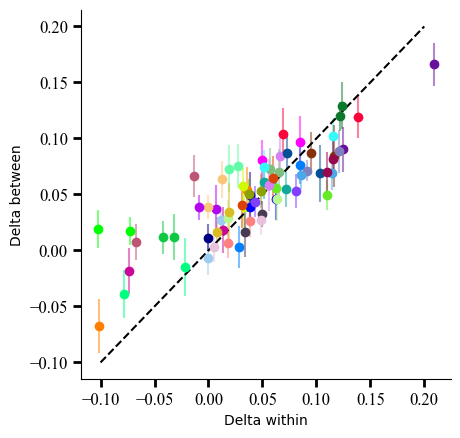

In [209]:
all_deltas_within = []
all_deltas_between = []
for monkey in ["magneto", "nano"]:
    for i, model in enumerate(full_model_list):

        delta_others = []
        delta_within = None
        for model2 in full_model_list:
            if "cornet" not in model2:
                #, "nano"
                i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all[monkey][model]}.npy').mean(axis=0)
                i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')

                i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

                corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
                if model != model2:
                    delta_others.append(np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst))
                elif model == model2:
                    delta_within = np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst)
        
                    all_deltas_within.append(delta_within)
        all_deltas_between.append(np.nanmean(delta_others))

        plt.scatter(delta_within, np.mean(np.array(delta_others)), color=colors[i], label=model, zorder=10)
        plt.errorbar(delta_within, np.mean(np.array(delta_others)),
                    yerr=nanmad(np.array(delta_others)), color=colors[i], alpha=0.5, zorder=0)

plt.plot([-0.1, 0.2], [-0.1, 0.2], color='black', linestyle='--')
#plt.scatter(np.nanmean(all_corrs_i1_best), np.nanmean(all_corrs_i1_worst), color="green", zorder=10)
plt.xlabel("Delta within")
plt.ylabel("Delta between")
journal_figure()
plt.savefig(f"./results_behavior/deltas_all_behavior_corrected_for_accuracy.eps", dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


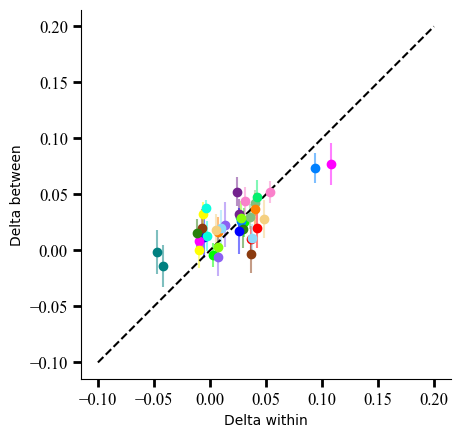

In [80]:
all_deltas_within = []
all_deltas_between = []
for monkey in ["magneto", "nano"]:
    for i, model in enumerate(prev_model_list):

        delta_others = []
        delta_within = None
        for model2 in prev_model_list:
            if "cornet" not in model2:
                #, "nano"
                i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all_one_to_one[monkey][model]}_one_to_one.npy').mean(axis=0)
                i1_bad = np.load(f'./results_behavior/{model}/{monkey}/one_to_one_i1_bad.npy')

                i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

                corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
                if model != model2:
                    delta_others.append(np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst))
                elif model == model2:
                    delta_within = np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst)
        
                    all_deltas_within.append(delta_within)
        all_deltas_between.append(np.nanmean(delta_others))

        plt.scatter(delta_within, np.mean(np.array(delta_others)), color=colors[i], label=model, zorder=10)
        plt.errorbar(delta_within, np.mean(np.array(delta_others)),
                    yerr=nanmad(np.array(delta_others)), color=colors[i], alpha=0.5, zorder=0)

plt.plot([-0.1, 0.2], [-0.1, 0.2], color='black', linestyle='--')
#plt.scatter(np.nanmean(all_corrs_i1_best), np.nanmean(all_corrs_i1_worst), color="green", zorder=10)
plt.xlabel("Delta within")
plt.ylabel("Delta between")
journal_figure()
plt.savefig(f"./results_behavior/deltas_all_behavior_corrected_for_accuracy_one_to_one.eps", dpi=300)

In [192]:
all_deltas_within = []
all_deltas_between = []
for monkey in ["magneto", "nano"]:
    
    for i, model in enumerate(full_model_list):
        if "cornet" not in model:
            delta_others = []
            delta_within = None
            for model2 in full_model_list:
                if "cornet" not in model2:
                    #, "nano"
                    i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all[monkey][model]}.npy').mean(axis=0)
                    i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')

                    i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

                    corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
                    if model != model2:
                        delta_others.append(np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst))
                    elif model == model2:
                        delta_within = np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst)
            
                        all_deltas_within.append(delta_within)
            all_deltas_between.append(np.nanmean(delta_others))

In [81]:
all_deltas_within = []
all_deltas_between = []
for monkey in ["magneto", "nano"]:
    
    for i, model in enumerate(prev_model_list):
        if "cornet" not in model:
            delta_others = []
            delta_within = None
            for model2 in prev_model_list:
                if "cornet" not in model2:
                    #, "nano"
                    i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all_one_to_one[monkey][model]}_one_to_one.npy').mean(axis=0)
                    i1_bad = np.load(f'./results_behavior/{model}/{monkey}/one_to_one_i1_bad.npy')

                    i1_behavior = np.load(f'./results_behavior/{model2}/behavior_i1.npy')

                    corr_best, corr_worst, corrs_i1_best, corrs_i1_worst  = compute_all_correlations(i1_good, i1_bad, i1_behavior)
                    if model != model2:
                        delta_others.append(np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst))
                    elif model == model2:
                        delta_within = np.nanmean(corrs_i1_best) - np.nanmean(corrs_i1_worst)
            
                        all_deltas_within.append(delta_within)
            all_deltas_between.append(np.nanmean(delta_others))

In [82]:
stats.shapiro(all_deltas_within), stats.shapiro(all_deltas_between)

(ShapiroResult(statistic=np.float64(0.957213785097059), pvalue=np.float64(0.15392063622948562)),
 ShapiroResult(statistic=np.float64(0.9687950781710761), pvalue=np.float64(0.3603306658899026)))

In [83]:
len(all_deltas_within), len(all_deltas_between)

(38, 38)

In [84]:
def print_ttest(commons, uniques):
    stat, p = stats.ttest_rel(commons, uniques, alternative="less")
    dof = len(commons) + len(uniques) - 2
    print(f"t({dof}) = {stat}, p = {p}")

In [85]:
print_ttest(all_deltas_within, all_deltas_between)

t(74) = -1.9005411738653613, p = 0.03258737395173922


In [86]:
b_nano = np.load("./results_behavior/i1_nano.npy")
b_magneto = np.load("./results_behavior/i1_magneto.npy")
b_bento = np.load("./results_behavior/i1_bento.npy")
b_human = np.load("./results_behavior/i1_human.npy")



In [87]:
def compute_correlation_monkeys(d1, d2):  
    rand_r1 = np.random.choice(20, size=20, replace=True)  
    rand_r2 = np.random.choice(20, size=20, replace=True)  
    corrs_i1 = [  
        pearsonr(d1[:], d2[:, r2])[0]  
        for r1, r2 in zip(rand_r1, rand_r2)  
        ]  
    mean_corr = np.nanmean(corrs_i1)  
    std_corr = np.nanmean(corrs_i1)/np.sqrt(1320)  
    return mean_corr, std_corr, corrs_i1  
  
def compute_all_correlations(i1_model_best, i1_model_worst, i1_b, ceiling_b=1.0, ceiling_db=1.0, ceiling_dw=1.0): #, ceiling_b):  
    corr_best_m, corr_best_std, corrs_i1_best = compute_correlation_monkeys(i1_b, i1_model_best)  
    corr_worst_m, corr_worst_std, corrs_i1_worst = compute_correlation_monkeys(i1_b, i1_model_worst)    
    corr_best_m_corr = corr_best_m/np.sqrt(ceiling_b*ceiling_db)  
    corr_worst_m_corr = corr_worst_m/np.sqrt(ceiling_b*ceiling_dw)  
  
    return corr_best_m_corr, corr_worst_m_corr, corrs_i1_best, corrs_i1_worst

In [88]:
ceiling_b_magneto = 0.8724219
ceiling_b_nano = 0.868336
ceiling_b_bento = 0.7774685
ceiling_b_human = 0.892218

In [89]:
dict_bi1={  
    "nano": b_nano,  
    "magneto": b_magneto,  
    "bento": b_bento,  
    "human": b_human,  
    }  
  
dict_bc={  
    "nano": ceiling_b_nano,  
    "magneto": ceiling_b_magneto,  
    "bento": ceiling_b_bento,  
    "human": ceiling_b_human,  
    }  

In [90]:
def compute_correlation_monkeys(d1, d2):
    rand_r1 = np.random.choice(20, size=20, replace=True)
    rand_r2 = np.random.choice(20, size=20, replace=True)
    corrs_i1 = [
        pearsonr(d1[:], d2[:, r2])[0]
        for r1, r2 in zip(rand_r1, rand_r2)
    ]
    mean_corr = np.nanmean(corrs_i1)
    std_corr = np.nanmean(corrs_i1)/np.sqrt(1320)

    return mean_corr, std_corr, corrs_i1

def compute_all_correlations(i1_model_best, i1_model_worst, i1_b, ceiling_b=1.0, ceiling_db=1.0, ceiling_dw=1.0): #, ceiling_b):
    corr_best_m, corr_best_std, corrs_i1_best = compute_correlation_monkeys(i1_b, i1_model_best)
    corr_worst_m, corr_worst_std, corrs_i1_worst = compute_correlation_monkeys(i1_b, i1_model_worst)

    corr_best_m_corr = corr_best_m/np.sqrt(ceiling_b*ceiling_db)
    corr_worst_m_corr = corr_worst_m/np.sqrt(ceiling_b*ceiling_dw)

    return corr_best_m_corr, corr_worst_m_corr, corrs_i1_best, corrs_i1_worst

In [123]:
colors=["#DC5069", "#836996", "#F8D45C", "#70BDA5"]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


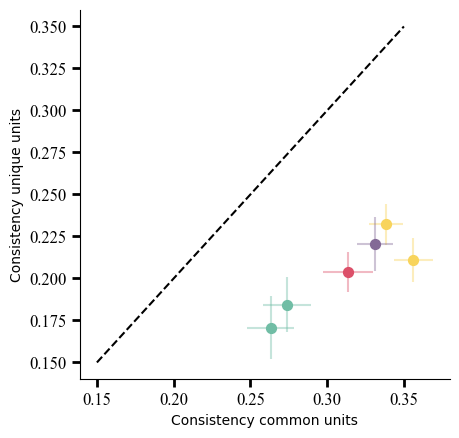

In [124]:
commons = []
uniques = []
for monkey in ["magneto", "nano"]:
    
    for model in ["resnet"]:
        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_[monkey]}.npy').mean(axis=0)
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
        corrs = {}
        corrs_g = []
        corrs_b = []
        i=0
        for key, item in dict_bi1.items():
            if monkey == key:
                i+=1
                continue
            corr_best_corr, corr_worst_corr, corrs_i1_best, corrs_i1_worst = compute_all_correlations(i1_good, i1_bad, item, dict_bc[key], 1.0, 1.0)
            corrs[key] = {}
            corrs[key]["good"] = np.array(corrs_i1_best)
            corrs[key]["bad"] = np.array(corrs_i1_worst)

            corrs_g.append(corrs[key]["good"].mean())
            corrs_b.append(corrs[key]["bad"].mean())
            commons.append(corrs[key]["good"].mean())
            uniques.append(corrs[key]["bad"].mean())

            plt.scatter(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), 50, marker="o", color=colors[i])
            plt.errorbar(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), xerr=corrs[key]["good"].std(), yerr=corrs[key]["bad"].std(), alpha=0.4, color=colors[i])        

            i+=1


plt.plot([0.15, 0.35], [0.15, 0.35], color="black", linestyle="--")
plt.xlabel("Consistency common units")
plt.ylabel("Consistency unique units")
journal_figure()
plt.savefig("./figures/plots_v2/resnet_to_models_primate_behavior_corrected_for_accuracy.eps")    
plt.show()           

In [125]:
stats.shapiro(commons), stats.shapiro(uniques)

(ShapiroResult(statistic=np.float64(0.9209765952807385), pvalue=np.float64(0.5124224213686761)),
 ShapiroResult(statistic=np.float64(0.9699917527833108), pvalue=np.float64(0.8923790076674144)))

In [126]:
def print_ttest(commons, uniques):
    stat, p = stats.ttest_rel(commons, uniques, alternative='greater')
    dof = len(commons) - 1
    print(f"t({dof}) = {stat}, p = {p}")

In [127]:
print_ttest(commons, uniques)

t(5) = 13.431226328298841, p = 2.0475834177920837e-05


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


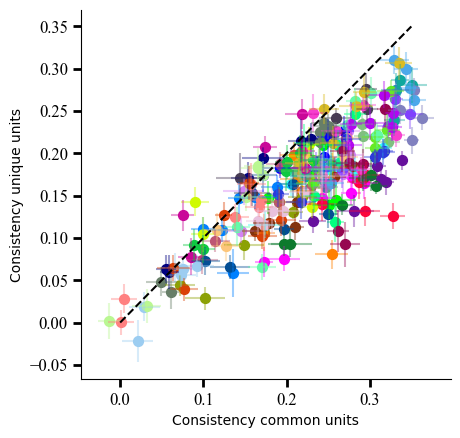

In [213]:
commons = []
uniques = []
for i, model in enumerate(full_model_list):
    for monkey in ["magneto", "nano"]:

        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all[monkey][model]}.npy').mean(axis=0)
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/i1_bad.npy')
        corrs = {}
        corrs_g = []
        corrs_b = []
        #i=0
        for key, item in dict_bi1.items():
            if monkey == key:
                # i+=1
                continue
            corr_best_corr, corr_worst_corr, corrs_i1_best, corrs_i1_worst = compute_all_correlations(i1_good, i1_bad, item, dict_bc[key], 1.0, 1.0)
            corrs[key] = {}
            corrs[key]["good"] = np.array(corrs_i1_best)
            corrs[key]["bad"] = np.array(corrs_i1_worst)

            corrs_g.append(corrs[key]["good"].mean())
            corrs_b.append(corrs[key]["bad"].mean())
            commons.append(corrs[key]["good"].mean())
            uniques.append(corrs[key]["bad"].mean())

            plt.scatter(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), 50, marker="o", color=colors[i])
            plt.errorbar(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), xerr=corrs[key]["good"].std(), yerr=corrs[key]["bad"].std(), alpha=0.4, color=colors[i])        

            # i+=1


plt.plot([0.0, 0.35], [0.0, 0.35], color="black", linestyle="--")
plt.xlabel("Consistency common units")
plt.ylabel("Consistency unique units")
journal_figure()
plt.savefig("./figures/plots_v2/all_models_primate_behavior_corrected_for_accuracy.eps")    
plt.show()           

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


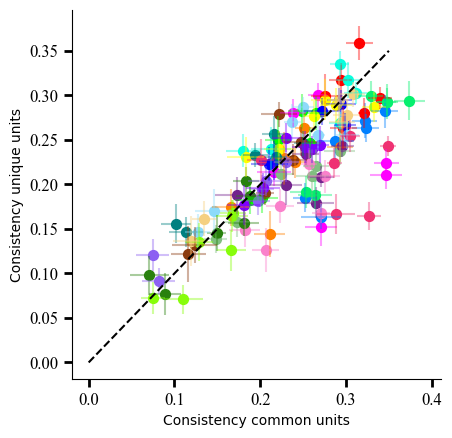

In [91]:
commons = []
uniques = []
for i, model in enumerate(prev_model_list):
    for monkey in ["magneto", "nano"]:

        i1_good = np.load(f'./results_behavior/{model}/{monkey}/i1_good_{sample_size_best_match_all_one_to_one[monkey][model]}_one_to_one.npy').mean(axis=0)
        i1_bad = np.load(f'./results_behavior/{model}/{monkey}/one_to_one_i1_bad.npy')
        corrs = {}
        corrs_g = []
        corrs_b = []
        #i=0
        for key, item in dict_bi1.items():
            if monkey == key:
                # i+=1
                continue
            corr_best_corr, corr_worst_corr, corrs_i1_best, corrs_i1_worst = compute_all_correlations(i1_good, i1_bad, item, dict_bc[key], 1.0, 1.0)
            corrs[key] = {}
            corrs[key]["good"] = np.array(corrs_i1_best)
            corrs[key]["bad"] = np.array(corrs_i1_worst)

            corrs_g.append(corrs[key]["good"].mean())
            corrs_b.append(corrs[key]["bad"].mean())
            commons.append(corrs[key]["good"].mean())
            uniques.append(corrs[key]["bad"].mean())

            plt.scatter(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), 50, marker="o", color=colors[i])
            plt.errorbar(corrs[key]["good"].mean(), corrs[key]["bad"].mean(), xerr=corrs[key]["good"].std(), yerr=corrs[key]["bad"].std(), alpha=0.4, color=colors[i])        

            # i+=1


plt.plot([0.0, 0.35], [0.0, 0.35], color="black", linestyle="--")
plt.xlabel("Consistency common units")
plt.ylabel("Consistency unique units")
journal_figure()
plt.savefig("./figures/plots_v2/all_models_primate_behavior_corrected_for_accuracy_one_to_one.eps")    
plt.show()           

In [92]:
stats.shapiro(commons), stats.shapiro(uniques)

(ShapiroResult(statistic=np.float64(0.9717683032670833), pvalue=np.float64(0.009701367877324316)),
 ShapiroResult(statistic=np.float64(0.9789148131182057), pvalue=np.float64(0.04627728241605919)))

In [93]:
def print_wilcoxon(commons, uniques):
    stat, p = stats.wilcoxon(commons, uniques, alternative='greater')
    dof = len(commons) - 1
    print(f"W({dof}) = {stat}, p = {p}")

In [94]:
print_wilcoxon(commons, uniques=uniques)

W(125) = 5409.0, p = 0.00030248562470852077


In [53]:
def print_ttest(commons, uniques):
    stat, p = stats.ttest_ind(commons, uniques, alternative='greater')
    dof = len(commons) + len(uniques) - 2
    print(f"t({dof}) = {stat}, p = {p}")

In [54]:
print_ttest(commons, uniques)

t(250) = 1.979023196824637, p = 0.02445533293199006
